<hr>
<div><h1 align=center><font style="font-style:italic;">近年部分城市空气质量与天气及工业等人类活动关系研究</font></h1></div>
<div><h3 align=center>作者：<font style="font-style:italic;">方俊杰</font></h3></div>

## 一.项目简介
#### 1. 问题背景
    进入冬天，全国较多城市尤其北京等北方城市又开始空气重污染情况，出现雾霾等恶劣天气，对人体健康造成很大影响。而雾霾等的空气污染与城市的天气情况、工业排放及其他人类活动存在一定的联系。2013年，“雾霾”成为年度关键词。这一年的1月，4次雾霾过程笼罩30个省（区、市），在北京，仅有5天不是雾霾天。2017年，李克强总理亲自将“坚决打好蓝天保卫战”写入报告，近年来，国家在环境保护上开展了大量的工作。
#### 2. 问题阐述
    希望通过使用课上学习的技术理论知识，收集近年来部分城市的空气质量情况以及相应的天气情况、工业产值等数据，进行统计分析，显现近年来部分城市空气质量变化情况与天气、工业等的关系
#### 3. 项目预期达到的效果
    1. 希望实现爬虫获取数据集，了解爬虫的基本过程，实现方法
    2. 对获取的数据进行预处理、合并等操作，实践真实需求下的预处理过程
    3. 对预处理后的数据进行统计分析可视化等操作，实践数据处理分析的过程
    4. 对于空气污染的问题，得出一些结论，比如空气污染与上述因素的关联程度，治理的效果等
    5. 希望应用基础的机器学习框架，实现对未来空气污染情况变化的预测，实践机器学习在项目中的应用
    

## 二.数据收集
#### 1. 数据集来源
   - 空气质量数据：[天气后报空气质量历史数据](http://www.tianqihoubao.com/aqi/)
   - 天气变化数据：[天气后报历史天气数据](http://www.tianqihoubao.com/lishi/)
   - 工业产值数据：
       * 发电量数据:  [国家统计局](http://data.stats.gov.cn/easyquery.htm?cn=E0101)
       * 原煤产量数据：[国家统计局](http://data.stats.gov.cn/easyquery.htm?cn=E0101)

#### 2. 数据集收集
* 应用爬虫爬取了天气后报中全国各省会城市、直辖市2014年以来的每日空气质量数据
 * 注：港澳台空气质量数据缺失
* 应用爬虫爬取了天气后报中全国各省会城市、直辖市2013年以来的每日天气数据
 * 注：以上两个数据爬虫代码见 **项目数据收集_天气数据**和**项目数据收集_空气质量**notebook
* 从国家统计局直接分别获取了各省、直辖市自2014年以来每月发电量数据及2015年以来每月原煤产量数据
 * 注：国家统计局不公布每年一月份的数据
 * 注：某些直辖市数据缺失
 * 注：国家统计局仅公布了省级数据，而不是省会城市数据，可能省会城市数据需要更深入的搜索

## 三. 数据预处理
#### 导入所需的依赖库：pandas，matplotlib

In [72]:
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import seaborn as sns
import numpy as np
from scipy import stats

# 作 中国地图 
from mpl_toolkits.basemap import Basemap
# 决策树使用
from sklearn import tree
from sklearn.metrics import accuracy_score,confusion_matrix
# 决策树可视化
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
import os     
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline  

In [3]:

provinceSet = ['北京', '天津', '河北', '山西', '内蒙古', '辽宁', '吉林',
               '黑龙江', '上海', '江苏', '浙江', '安徽', '福建', '江西', '山东',
               '河南', '湖北', '湖南', '广东', '广西', '海南', '重庆', '四川',
               '贵州', '云南', '西藏', '陕西', '甘肃', '青海', '宁夏', '新疆']
citySet = ['beijing', 'tianjin', 'shijiazhuang', 'taiyuan', 'huhehaote', 'shenyang', 'changchun',
            'haerbin', 'shanghai', 'nanjing', 'hangzhou', 'hefei', 'fujianfuzhou', 'nanchang', 'jinan',
            'zhengzhou', 'wuhan', 'changsha', 'guangzhou', 'nanning', 'haikou', 'chongqing', 'chengdu',
            'guiyang', 'kunming', 'lasa', 'xian', 'lanzhou', 'xining', 'yinchuan', 'wulumuqi']
print(len(provinceSet))
print(len(citySet))

31
31


### 发电量数据预处理
* 获得的数据是**31个省或直辖市2014到2018年发电量当期值及其同比增长、累计值及其累计增长**的数据表
* 仅将每个省或直辖市的**发电量当期值**合并到一个DataFrame保存为power_cleaned.csv文件备用
* csv文件前三行和后两行属于注释型信息，读取时跳过
* 统计网数据中2016/2017/2018年无1月2月单独数据，仅两月累加值，而2014/2015年无1月份数据，但有前二月累加值，可以计算得到1月份数据，进而比对发现，1月份发电量数据大致比2月份大两月累加值的6%左右，用此来估算填充近3年1月2月数据
* 2018年11月数据不存在，删除该列
* 另外发现，河南省2015年3月数据缺失，使用前后两月累计值计算


#### 查看单表格数据

In [132]:
tmp = pd.read_csv("data/power/发电-北京.csv",skiprows=3,skipfooter=2, encoding="gbk", engine='python')
tmp.head()

,指标,2018年11月,2018年10月,2018年9月,2018年8月,2018年7月,2018年6月,2018年5月,2018年4月,2018年3月,...,2014年10月,2014年9月,2014年8月,2014年7月,2014年6月,2014年5月,2014年4月,2014年3月,2014年2月,2014年1月
0,发电量当期值(亿千瓦时),NaN,27.5,28.9,43.2,41.8,36.3,26.2,23.3,35.9,...,19.4,16.3,27.1,35.5,24.8,21.3,21.3,28.9,32.3,NaN
1,发电量累计值(亿千瓦时),NaN,344.5,317.0,288.0,244.9,203.1,166.8,140.6,117.4,...,264.5,245.2,228.9,201.8,166.2,141.4,120.1,98.8,69.9,NaN
2,发电量同比增长(%),NaN,13.8,26.0,26.1,14.3,38.4,11.3,15.2,5.2,...,2.2,-17.4,-22.1,27.7,27.7,-11.9,1.7,-8.2,0.3,NaN
3,发电量累计增长(%),NaN,11.4,11.2,9.9,7.5,6.2,1.1,-0.6,-3.3,...,0.0,-0.2,1.4,5.6,1.8,-1.7,0.4,0.1,3.9,NaN


#### 处理每个省或直辖市的发电量数据表，提取其中的发电量当期值进行插值后合并到一个数据表

In [912]:
def dealOne(province):
    # skip head 3, foot 2, and skipfoot need python engine
    dfPowerByProvince = pd.read_csv("data/power/发电-"+province+".csv",skiprows=3,skipfooter=2, encoding="gbk", engine='python')
    # 插值, 用2014年数据发现，1月的发电量大致要比2月大两个月总量的6%左右
    dfPowerByProvince.loc[0,'2018年2月'] = dfPowerByProvince.loc[1,'2018年2月']*0.47
    dfPowerByProvince.loc[0,'2018年1月'] = dfPowerByProvince.loc[1,'2018年2月']*0.53
    dfPowerByProvince.loc[0,'2017年2月'] = dfPowerByProvince.loc[1,'2017年2月']*0.47
    dfPowerByProvince.loc[0,'2017年1月'] = dfPowerByProvince.loc[1,'2017年2月']*0.53
    dfPowerByProvince.loc[0,'2016年2月'] = dfPowerByProvince.loc[1,'2016年2月']*0.47
    dfPowerByProvince.loc[0,'2016年1月'] = dfPowerByProvince.loc[1,'2016年2月']*0.53
    # 2014 2015年存在2月数据，可以直接由累加值减2月计算
    dfPowerByProvince.loc[0,'2015年1月'] = dfPowerByProvince.loc[1,'2015年2月'] - dfPowerByProvince.loc[0,'2015年2月']
    dfPowerByProvince.loc[0,'2014年1月'] = dfPowerByProvince.loc[1,'2014年2月'] - dfPowerByProvince.loc[0,'2014年2月']
    if (province == '河南'):
        dfPowerByProvince.loc[0,'2015年3月'] = dfPowerByProvince.loc[1,'2015年4月'] \
                                                - dfPowerByProvince.loc[0,'2015年4月'] - dfPowerByProvince.loc[1,'2015年2月']
    dfPowerByProvince.rename(columns={'指标':'place'}, inplace=True)
    dfPowerByProvince.loc[0, 'place'] = province
    return dfPowerByProvince.head(1)

for province in provinceSet:
    if (province == '北京'):
        power = dealOne(province)
    else:
        power = pd.concat([power, dealOne(province)], axis=0)

# fix index
power.index = range(len(power))
# change month name format from 2018年10月 to 2018.10
power.rename(columns=lambda x:x.replace('年','-'), inplace=True)
power.rename(columns=lambda x:x.replace('月',''), inplace=True)
# delete 2018年11月 missing data
del power['2018-11']

power.head()
# power.shape  # (31,60)

,place,2018-10,2018-9,2018-8,2018-7,2018-6,2018-5,2018-4,2018-3,2018-2,...,2014-10,2014-9,2014-8,2014-7,2014-6,2014-5,2014-4,2014-3,2014-2,2014-1
0,北京,27.5,28.9,43.2,41.8,36.3,26.2,23.3,35.9,38.305,...,19.4,16.3,27.1,35.5,24.8,21.3,21.3,28.9,32.3,37.6
1,天津,52.3,56.7,75.4,69.2,61.7,46.7,45.9,49.7,49.491,...,46.8,51.6,59.3,58.6,51.0,46.9,42.7,51.2,47.4,53.9
2,河北,229.6,224.4,269.7,285.1,251.3,233.7,222.1,233.6,231.898,...,191.1,191.3,217.6,233.0,217.5,218.4,206.8,210.0,176.7,205.5
3,山西,240.2,234.2,280.3,276.0,247.0,227.8,224.7,245.7,231.287,...,206.3,204.8,231.1,233.7,205.8,208.6,213.3,229.9,202.1,232.2
4,内蒙古,419.0,395.7,424.9,405.9,372.3,415.3,393.6,396.1,344.839,...,301.5,308.0,317.8,318.5,302.9,299.8,303.9,306.2,268.4,290.5


#### 导出合并的数据表

In [913]:
# export cleaned power data
power.to_csv("data/power_cleaned.csv", index=False)

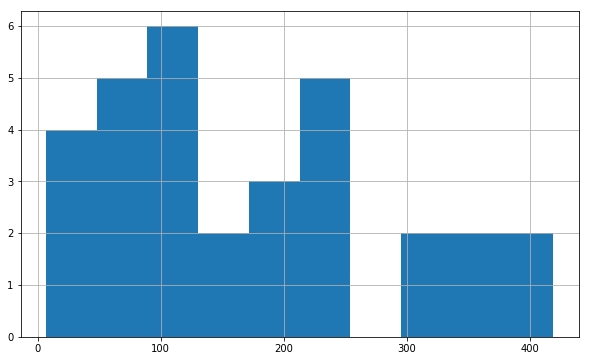

In [915]:
power['2018-10'].hist(figsize=[10,6])

### 原煤产量数据预处理
* 获得的数据是**26个省或直辖市2015到2018年发电量当期值及其同比增长、累计值及其累计增长**的数据表
* csv文件前三行和后两行属于注释型信息，读取时跳过
* 发现统计局**未公布天津、上海、浙江、广东、海南数据**，且数据量仅从2015年开始，暂时考虑**不使用**该数据集

In [137]:
print("以下省或直辖市数据缺失：")
for province in provinceSet:
    try:
        tmp = pd.read_csv("data/rawCoal/原煤-"+province+".csv",skiprows=3,skipfooter=2, encoding="gbk", engine='python')
    except:
        print(province)

以下省或直辖市数据缺失：
天津
上海
浙江
广东
海南


### 空气质量数据预处理
* 获取的数据是**31个省会城市或直辖市2014年1月1日以来每日质量等级、AQI指数、当日AQI排名、PM2.5等空气污染物指标**的数据表
* 将每个数据表的AQI指数列合并保存为aqiAllCity.csv
* 将每个城市的每日数据按月聚合求平均值导出为aqiByMonth.csv
* AQI:空气污染指数，就是根据环境空气质量标准和各项污染物对人体健康、生态、环境的影响，将常规监测的几种空气污染物浓度简化成为单一的概念性指数值形式

#### 读取一个空气质量数据表展示前5行

In [729]:
aqitmp = pd.read_csv("data/aqi/beijing.csv",encoding="gbk")
aqitmp.head()

,日期,质量等级,AQI指数,当天AQI排名,PM2.5,PM10,So2,No2,Co,O3
0,2014-01-01,良,86,31,44,110,27,62,1.48,27
1,2014-01-02,轻度污染,117,65,110,166,71,92,3.40,8
2,2014-01-03,良,80,29,46,97,28,52,1.30,32
3,2014-01-04,中度污染,153,127,116,149,40,76,2.84,4
4,2014-01-05,轻度污染,119,48,89,116,35,67,2.29,15


#### 以城市名重命名AQI指数列，合并所有数据表的该列并导出

In [778]:
aqiAllCity = aqitmp[['日期']]
for city in citySet:
    aqiByCity = pd.read_csv("data/aqi/"+city+".csv",encoding="gbk")
    aqiByCity.rename(columns={'AQI指数':city+'AQI'}, inplace=True)
    aqiAllCity = pd.concat([aqiAllCity, aqiByCity[city+'AQI']], axis=1)
aqiAllCity.head()
# aqiAllCity.shape #(1788,32)

,日期,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
0,2014-01-01,86,141,86,88,146,85.0,62,121,168.0,...,149,241,128,71,57,108,162,92,66,242
1,2014-01-02,117,142,153,104,120,72.0,69,133,166.0,...,167,231,143,57,52,126,128,72,72,176
2,2014-01-03,80,115,144,80,103,62.0,120,188,182.0,...,208,190,110,81,50,92,101,92,60,249
3,2014-01-04,153,69,241,103,117,138.0,140,240,144.0,...,205,186,121,104,50,114,122,73,57,252
4,2014-01-05,119,121,290,93,82,123.0,250,407,64.0,...,210,253,153,62,77,199,116,84,78,137


#### 导出合并后的AQI指数数据表

In [780]:
# export all cities aqi data
aqiAllCity.to_csv("data/aqiAllCity.csv", index=False)


#### 按月聚合每个城市的数据，取平均值导出
* 使用了 **时间索引**
* 用resample方法聚合取平均值，用to_period以每月粒度显示，否则显示会到日
* 注意原数据中存在重复日期，先去除

In [830]:
# node: assign is not copy!!!!!!
aqiAllCityTmp = aqiAllCity.copy()
aqiAllCityTmp.drop_duplicates(subset='日期',keep='first',inplace=True)
aqiAllCityTmp

# set_index no use, why
#aqiAllCityTmp['日期'] = pd.to_datetime(aqiAllCityTmp['日期'])
#aqiAllCityTmp.set_index(pd.DatetimeIndex(aqiAllCityTmp['日期']))

dateIndex = aqiAllCityTmp['日期']
del aqiAllCityTmp['日期']
aqiIndexDate = pd.DataFrame(data = aqiAllCityTmp.values, 
                            index=pd.to_datetime(dateIndex), 
                            columns=aqiAllCityTmp.columns.values)
print(type(aqiIndexDate.index))
aqiByMonthIndex = aqiIndexDate.resample('M').mean().to_period('M')
aqiByMonthIndex

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,nanjingAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
日期,,,,,,,,,,,,,,,,,,,,,
2014-01,121.000000,147.966667,297.333333,113.833333,92.733333,118.466667,120.166667,159.200000,103.733333,167.533333,...,171.400000,218.266667,123.033333,68.100000,51.100000,182.533333,108.333333,117.566667,90.466667,162.433333
2014-02,183.071429,128.642857,260.750000,135.178571,89.964286,130.750000,118.464286,149.250000,73.714286,104.107143,...,113.642857,147.071429,68.571429,50.392857,65.071429,214.607143,93.285714,116.285714,98.000000,109.285714
2014-03,126.833333,152.766667,190.866667,100.366667,96.033333,110.166667,95.266667,79.500000,82.500000,110.633333,...,76.600000,115.333333,65.000000,74.633333,54.766667,138.200000,100.833333,110.466667,94.666667,126.966667
2014-04,129.800000,123.900000,155.433333,100.933333,96.033333,100.766667,93.666667,81.400000,76.933333,89.500000,...,62.966667,86.966667,64.500000,77.966667,69.666667,102.466667,109.866667,113.400000,96.366667,147.200000
2014-05,100.741935,104.483871,127.193548,92.870968,94.032258,82.322581,63.096774,50.838710,94.225806,128.161290,...,70.322581,107.806452,67.096774,56.516129,68.967742,101.645161,104.000000,106.548387,75.580645,109.096774
2014-06,91.966667,90.900000,123.766667,76.700000,71.600000,79.366667,69.600000,55.400000,66.366667,120.100000,...,56.233333,67.833333,56.766667,42.566667,60.433333,77.500000,79.466667,71.400000,61.433333,82.433333
2014-07,130.548387,112.967742,130.612903,84.258065,77.741935,85.516129,81.741935,71.677419,68.806452,92.774194,...,62.709677,66.451613,44.032258,42.903226,42.580645,72.903226,71.935484,67.290323,70.419355,87.548387
2014-08,98.965517,85.689655,103.413793,70.862069,70.827586,79.655172,67.172414,50.689655,60.068966,60.862069,...,57.241379,62.517241,46.379310,42.724138,46.827586,74.827586,71.896552,74.827586,65.758621,98.413793
2014-09,94.300000,81.966667,96.633333,72.966667,69.333333,71.566667,58.000000,42.766667,60.900000,74.900000,...,59.700000,60.433333,49.466667,44.800000,44.466667,61.766667,72.766667,71.500000,64.333333,106.600000


#### 导出按月平均AQI指数表

In [831]:
aqiByMonthIndex.to_csv("data/aqiByMonth.csv",index=True)

### 天气数据预处理
* 获取的数据是**31个省会城市或直辖市2013年1月1日以来每日天气状况、气温、风力风向**的数据表
* 由于空气质量数据仅有2014年开始的，因而跳过2013年数据读取
* 文本处理来获取**是否有雨、最高气温、最低气温、最大风力**作为新列插入数据表(存在风力为微风，**视为0级**)
* 原数据中，某些地区(如北京)2018年7月7日出现了两次，删除之
* 原数据中，存在日期缺失，如海口2016年10月31日不存在

#### 读取一个天气数据表展示前5行

In [518]:
headers = ['日期','天气状况','气温','风力风向']
weatherTmp = pd.read_csv("data/weather/beijing.csv",skiprows=366,encoding='gbk',names=headers)
weatherTmp.head()

,日期,天气状况,气温,风力风向
0,2014年1月1日,晴/晴,10℃/-4℃,无持续风向≤3级/无持续风向≤3级
1,2014年1月2日,晴/晴,8℃/-2℃,无持续风向≤3级/无持续风向≤3级
2,2014年1月3日,晴/晴,9℃/-5℃,北风3-4级/无持续风向≤3级
3,2014年1月4日,多云/多云,3℃/-3℃,无持续风向≤3级/无持续风向≤3级
4,2014年1月5日,晴/阴,6℃/-4℃,无持续风向≤3级/无持续风向≤3级


#### 检查数据行数据不正确的数据表(应该有1795天)
* 用value_counts发现2018年1月1日在所有数据表中都出现了两次
* 发现以下城市日期数据不正确，检查之
    1. 北京、天津、石家庄、呼和浩特、沈阳、哈尔滨2018年7月7日数据重复
    2. 海口2016年10月31日、广州2017年1月30日、昆明2017年12月3日、西安2018年1月13日和2018年4月16日数据缺失，查询添加

In [519]:
# already repair, won't output again
for city in citySet:
    weatherTmp = pd.read_csv("data/weather/"+city+".csv",skiprows=366,encoding='gbk',names=headers)
    length = len(weatherTmp['日期'])
    if (length != 1796):
        print(city)

#### 天气数据存在重复日期

In [520]:
weatherTmp['日期'].value_counts()

2018年01月01日    2
2014年09月16日    1
2018年05月09日    1
2017年02月15日    1
2014年11月24日    1
2017年12月10日    1
2017年09月23日    1
2016年07月31日    1
2017年07月17日    1
2018年10月20日    1
2014年05月23日    1
2016年10月23日    1
2016年08月09日    1
2014年02月15日    1
2017年07月13日    1
2015年01月25日    1
2016年01月26日    1
2016年04月28日    1
2017年02月23日    1
2015年06月24日    1
2018年11月09日    1
2014年03月09日    1
2015年08月16日    1
2018年09月10日    1
2018年11月26日    1
2017年12月15日    1
2015年02月02日    1
2017年08月12日    1
2017年05月24日    1
2015年01月06日    1
              ..
2018年02月03日    1
2017年11月13日    1
2018年01月15日    1
2017年05月29日    1
2018年04月27日    1
2018年02月23日    1
2015年04月04日    1
2016年01月02日    1
2018年03月06日    1
2018年02月12日    1
2014年08月26日    1
2017年08月01日    1
2017年11月02日    1
2018年01月08日    1
2018年04月13日    1
2014年10月07日    1
2017年11月18日    1
2015年09月15日    1
2016年11月11日    1
2014年06月19日    1
2015年11月21日    1
2018年10月26日    1
2014年08月13日    1
2014年10月20日    1
2018年04月11日    1
2017年07月18日    1
2017年09月27日    1
2018年11月04日   

In [521]:
headers = ['日期','天气状况','气温','风力风向']
weatherTmp = pd.read_csv("data/weather/beijing.csv",skiprows=366,encoding='gbk',names=headers)
# change data format using to_datetime from %Y年%m月%d日 to %Y-%m-%d
weatherTmp['日期'] = pd.to_datetime(weatherTmp['日期'],format='%Y年%m月%d日')
# get rain or not
length = len(weatherTmp['气温'])
tmpSeries = weatherTmp['天气状况'].str.contains('雨')
weatherTmp['是否有雨'] = [1 if tmpSeries[i] else 0 for i in range(length)]
# get max and min temperature
tmpSeries = weatherTmp['气温'].str.findall(r'-?\d+')
weatherTmp['最高气温/℃'] = [tmpSeries[i][0] for i in range(length)]
weatherTmp['最低气温/℃'] = [tmpSeries[i][1] for i in range(length)]
# get max wind power
tmpSeries = weatherTmp['风力风向'].str.findall(r'\d+')
weatherTmp['最大风力/级'] = [max(tmpSeries[i]) for i in range(length)]

weatherTmp.head()

,日期,天气状况,气温,风力风向,是否有雨,最高气温/℃,最低气温/℃,最大风力/级
0,2014-01-01,晴/晴,10℃/-4℃,无持续风向≤3级/无持续风向≤3级,0,10,-4,3
1,2014-01-02,晴/晴,8℃/-2℃,无持续风向≤3级/无持续风向≤3级,0,8,-2,3
2,2014-01-03,晴/晴,9℃/-5℃,北风3-4级/无持续风向≤3级,0,9,-5,4
3,2014-01-04,多云/多云,3℃/-3℃,无持续风向≤3级/无持续风向≤3级,0,3,-3,3
4,2014-01-05,晴/阴,6℃/-4℃,无持续风向≤3级/无持续风向≤3级,0,6,-4,3


#### 用索引删除重复索引后重建索引

In [522]:
# delete all 2018-01-01 duplicate row
weatherTmp[weatherTmp['日期'].isin(['2018-01-01'])] # two rows
weatherTmp.drop([1462],inplace=True)
weatherTmp[weatherTmp['日期'].isin(['2018-01-01'])]
weatherTmp.index = range(weatherTmp.shape[0])

#### 将天气数据进行文本处理导出每个城市各天气属性数据表
* 跳过2013年即前366行，所以需要提供表头
* 使用RE提取每个城市最高气温、最低气温以及最大风力作为3个数据表导出
 * 注：风力存在微风，无数值，补0

In [540]:
# after make sure each data set the same rows
rainAllCity = weatherTmp[['日期']]
maxTemAllCity = weatherTmp[['日期']]
minTemAllCity = weatherTmp[['日期']]
maxWindAllCity = weatherTmp[['日期']]
length = len(weatherTmp['日期'])

for city in citySet:
    weatherByCity = pd.read_csv("data/weather/"+city+".csv",skiprows=366,encoding='gbk',names=headers)
    # delete all 2018-01-01 duplicate row which index 1462
    weatherByCity.drop([1462],inplace=True)
    weatherByCity.index = range(length)
    '''
    if (length != 1796):
        print(city)
    '''
    # get rain or not, rename
    tmpSeries = weatherByCity['天气状况'].str.contains('雨')
    rainAllCity[city+'是否有雨'] = [1 if tmpSeries[i] else 0 for i in range(length)]
    
    # get max and min temperature
    tmpSeries = weatherByCity['气温'].str.findall(r'-?\d+')
    maxTemAllCity[city+'最高气温/℃'] = [max(tmpSeries[i]) for i in range(length)]
    minTemAllCity[city+'最低气温/℃'] = [min(tmpSeries[i]) for i in range(length)]
    # get max wind power
    tmpSeries = weatherByCity['风力风向'].str.findall(r'\d+')
    # note, 微风 exists, add ['0'] prevent empty list
    for i in range(length):
        tmpSeries[i].append('0')
    maxWindAllCity[city+'最大风力/级'] = [max(tmpSeries[i]) for i in range(length)]

rainAllCity.to_csv("data/rainAllCity.csv", index=False)
maxTemAllCity.to_csv("data/maxTemAllCity.csv", index=False)
minTemAllCity.to_csv("data/minTemAllCity.csv", index=False)
maxWindAllCity.to_csv("data/maxWindAllCity.csv", index=False)
    

E:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
E:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

## 三.数据分析
#### 读入所有城市AQI数据，展示前5行

In [4]:
aqiAllCity = pd.read_csv("data/aqiAllCity.csv",encoding='gbk')
aqiAllCity.head()

,日期,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
0,2014-01-01,86,141,86,88,146,85.0,62,121,168.0,...,149,241,128,71,57,108,162,92,66,242
1,2014-01-02,117,142,153,104,120,72.0,69,133,166.0,...,167,231,143,57,52,126,128,72,72,176
2,2014-01-03,80,115,144,80,103,62.0,120,188,182.0,...,208,190,110,81,50,92,101,92,60,249
3,2014-01-04,153,69,241,103,117,138.0,140,240,144.0,...,205,186,121,104,50,114,122,73,57,252
4,2014-01-05,119,121,290,93,82,123.0,250,407,64.0,...,210,253,153,62,77,199,116,84,78,137


#### AQI数据表大小

In [5]:
aqiAllCity.shape  # (1788,32)

(1788, 32)

#### AQI数据表基本统计

In [6]:
aqiAllCity.describe()

,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,nanjingAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
count,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1782.000000,1788.000000,1788.000000,1786.000000,1788.000000,...,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.000000,1788.00000
mean,102.781879,100.526286,129.550895,98.859060,82.997763,88.933782,81.929530,85.361857,72.346585,83.953020,...,74.536353,87.374161,57.149888,51.667226,58.889262,106.246085,90.269016,84.349553,84.263982,109.08613
std,69.437499,56.208321,82.551161,48.589336,41.833202,49.197331,48.918918,64.140483,35.244520,41.685381,...,38.774040,47.712947,23.974056,16.508549,18.644707,62.926342,45.622435,43.078009,36.290883,73.74937
min,18.000000,25.000000,17.000000,21.000000,20.000000,18.000000,12.000000,16.000000,21.000000,20.000000,...,14.000000,17.000000,16.000000,17.000000,23.000000,19.000000,28.000000,25.000000,27.000000,17.00000
25%,53.000000,63.000000,74.000000,67.000000,56.000000,57.000000,51.000000,45.000000,47.000000,56.000000,...,50.000000,56.000000,41.000000,40.000000,46.000000,69.000000,66.000000,61.000000,63.000000,63.00000
50%,85.000000,85.000000,104.500000,89.000000,74.000000,76.000000,68.000000,63.000000,63.000000,76.000000,...,66.000000,75.000000,54.000000,50.000000,56.000000,87.500000,80.000000,76.000000,75.000000,83.00000
75%,130.000000,117.000000,154.250000,115.000000,98.000000,106.000000,96.000000,101.000000,87.750000,101.000000,...,87.000000,104.000000,68.000000,62.000000,68.000000,119.000000,101.000000,96.000000,92.000000,130.25000
max,478.000000,423.000000,500.000000,388.000000,484.000000,500.000000,425.000000,466.000000,270.000000,349.000000,...,262.000000,451.000000,217.000000,138.000000,201.000000,486.000000,500.000000,480.000000,452.000000,498.00000


#### 2014年以来每日北京AQI数据折线图
* 由于每日AQI变动过大，该折线图显示效果较差

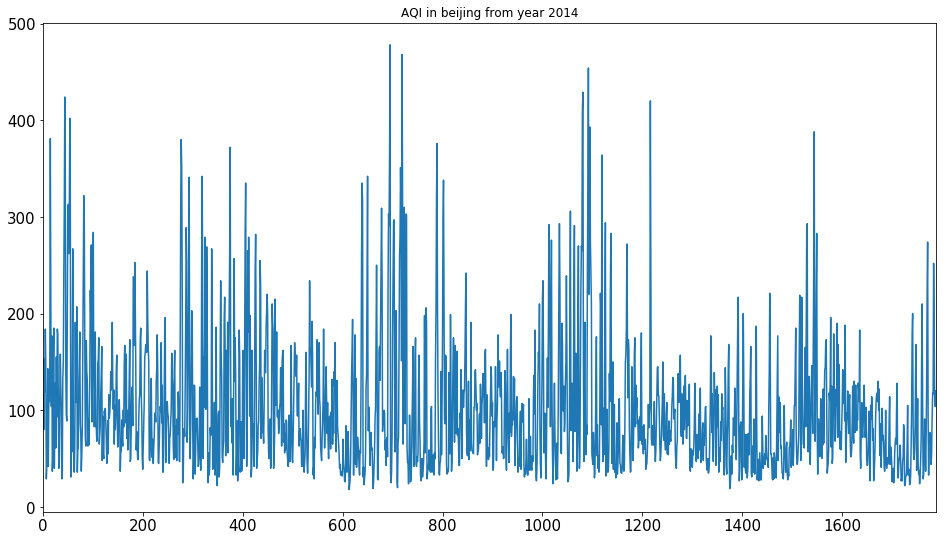

In [7]:
aqiAllCity['beijingAQI'].plot(kind = "line",figsize=[16,9],title='AQI in beijing from year 2014',fontsize=15)

#### 每个城市4年每日AQI指数箱线图
* 某些城市(如石家庄、济南、郑州、乌鲁木齐等)AQI指数平均值较大，波动范围较大

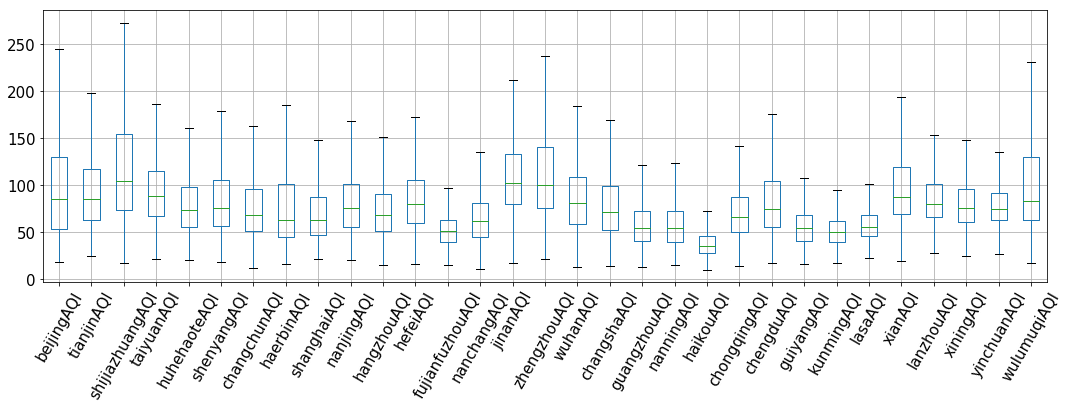

In [8]:
# 每个城市每日aqi指数的箱线图
aqiAllCity.boxplot(rot=60,showfliers=False, figsize=[18, 5],fontsize=15)


In [9]:
citySet = ['beijing', 'tianjin', 'shijiazhuang', 'taiyuan', 'huhehaote', 'shenyang', 'changchun',
            'haerbin', 'shanghai', 'nanjing', 'hangzhou', 'hefei', 'fujianfuzhou', 'nanchang', 'jinan',
            'zhengzhou', 'wuhan', 'changsha', 'guangzhou', 'nanning', 'haikou', 'chongqing', 'chengdu',
            'guiyang', 'kunming', 'lasa', 'xian', 'lanzhou', 'xining', 'yinchuan', 'wulumuqi']
stationDict = {'beijing':(116.41667,39.91667),'tianjin':(117.20000,39.13333),'shijiazhuang':(114.48333,38.03333),'taiyuan':(112.557546,37.878813),
               'huhehaote':(111.733665,40.84995),'shenyang':(123.365149,41.708853),'changchun':(125.321982,43.824452),'haerbin':(126.532987,45.811637),
              'shanghai':(121.471916,31.235435),'nanjing':(118.805871,32.0671),'hangzhou':(120.211486,30.254579),'hefei':(117.23689,31.826578),
              'fujianfuzhou':(119.30577,26.080429),'nanchang':(115.856536,28.684892),'jinan':(117.127549,36.65748),'zhengzhou':(113.627966,34.754389),
              'wuhan':(114.292614,30.600705),'changsha':(112.94317,28.235908),'guangzhou':(113.26683,23.136931),'nanning':(108.366555,22.823673),
              'haikou':(110.323226,20.046223),'chongqing':(106.554988,29.572012),'chengdu':(104.08038,30.654332),'guiyang':(106.629681,26.65539),
              'kunming':(102.848427,24.873473),'lasa':(91.120248,29.65004),'xian':(108.94704,34.351084),'lanzhou':(103.8365,36.066768),
             'xining':(101.78847,36.624775), 'yinchuan':(106.239646,38.492462),'wulumuqi':(87.620414,43.831179)}

#### 在空间维度上绘制每个城市的AQI平均值图
* 可以发现京津冀地区AQI指数较高，空气质量较差

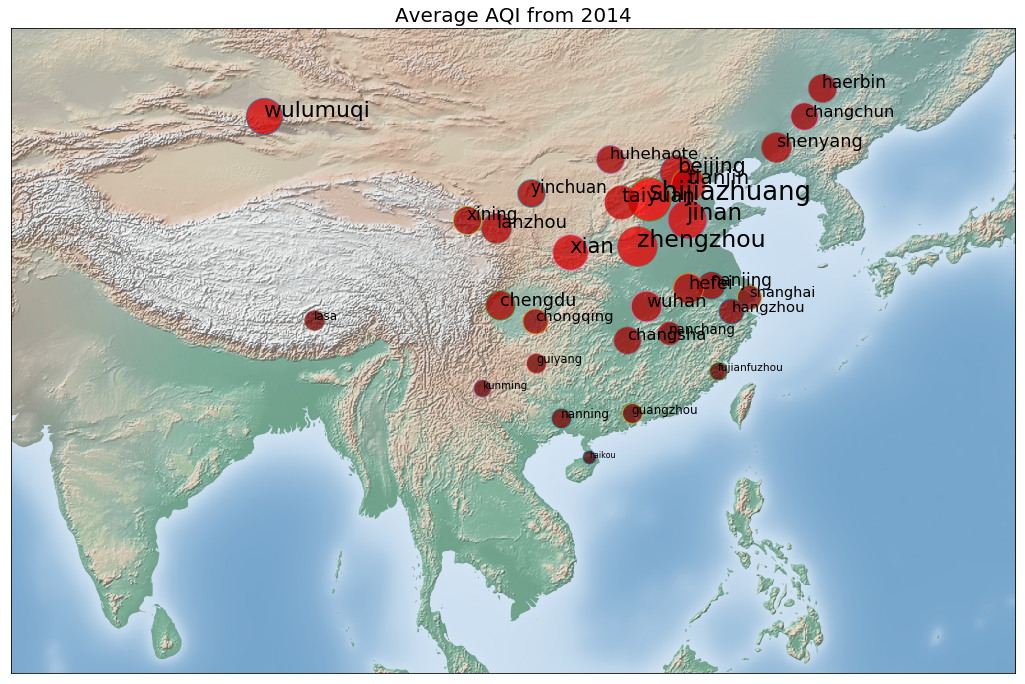

In [10]:
#increase figure size
from pylab import rcParams
rcParams['figure.figsize'] = (18,14)

my_map = Basemap(
            llcrnrlon=70, llcrnrlat=5, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=140, urcrnrlat=50 #max longitude (urcrnrlon) and latitude (urcrnrlat)
            )

maxAQI = max(aqiAllCity.describe().loc['mean'])
for city in citySet:
    lon = stationDict[city][0]
    lat = stationDict[city][1]
    val = aqiAllCity[city+'AQI'].mean()
    my_map.plot(lon,
                lat,
                markerfacecolor = (val/maxAQI,0,0), 
                marker='o', 
                markersize= val/3, 
                alpha = 0.75)
    plt.text(lon, lat, city,
             size = val/5, 
             color = "black")

#add title
plt.title("Average AQI from 2014", fontsize = 20)

my_map.shadedrelief()

rcParams['figure.figsize'] = (8,6)

#### 在时间维度上绘制平均AQI指数图
* 发现AQI指数季节性变化较大，冬季AQI指数较高，符合实际

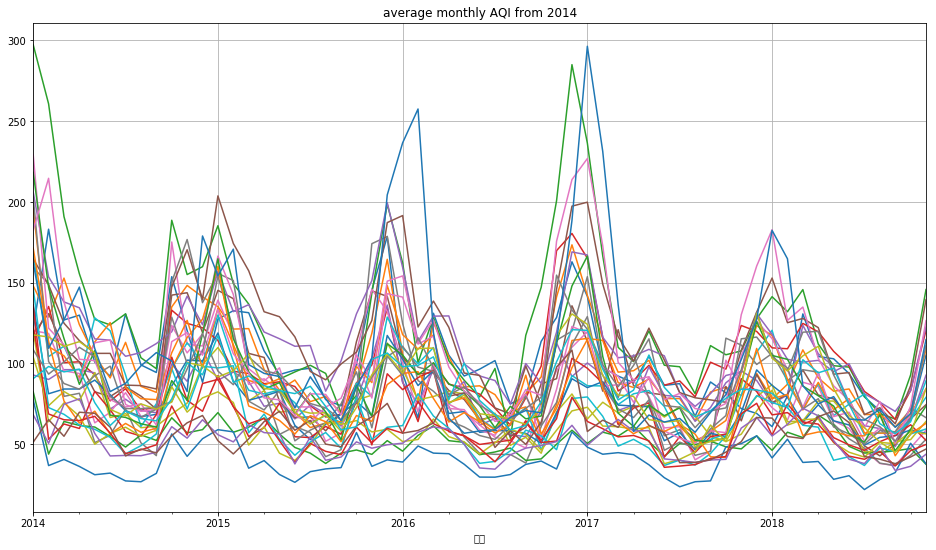

In [11]:
aqiByMonth = pd.read_csv("data/aqiByMonth.csv",encoding='gbk')
aqiByMonthTmp = pd.DataFrame(data = aqiByMonth.values, 
                            index=pd.to_datetime(aqiByMonth['日期']), 
                            columns=aqiByMonth.columns.values)
aqiByMonthTmp.plot(title="average monthly AQI from 2014", grid=True, legend=False,figsize=[16,9])

#### 读入之前处理完的4种天气数据表

In [12]:
rainAllCity = pd.read_csv("data/rainAllCity.csv",encoding='gbk')
maxTemAllCity = pd.read_csv("data/maxTemAllCity.csv",encoding='gbk')
minTemAllCity = pd.read_csv("data/minTemAllCity.csv",encoding='gbk')
maxWindAllCity = pd.read_csv("data/maxWindAllCity.csv",encoding='gbk')

#### 使用时发现aqi数据存在重复，且相对天气数据存在10天缺失
* 用差集获得为AQI指数相比天气缺失的日期
* 用value_counts获取AQI指数重复日期

In [13]:
print(rainAllCity.shape)
print(aqiAllCity.shape)
print(rainAllCity['日期'].unique().size)
print(aqiAllCity['日期'].unique().size)
aqiMissing = pd.Series(list(set(rainAllCity['日期']).difference(set(aqiAllCity['日期']))))
aqiMissing

(1795, 32)
(1788, 32)
1795
1785


0    2018-08-24
1    2014-03-24
2    2014-08-08
3    2014-08-22
4    2018-08-28
5    2014-01-23
6    2018-08-30
7    2018-09-01
8    2018-08-26
9    2017-10-04
dtype: object

#### 去除AQI指数重复数据

In [14]:
aqiAllCity.loc[aqiAllCity['日期'].duplicated() == True]


,日期,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
1205,2017-04-23,60,79,98,106,51,91.0,46,62,64.0,...,74,79,53,54,78,94,92,68,75,55
1233,2017-05-20,115,104,114,83,98,52.0,84,74,39.0,...,57,100,35,51,53,72,71,80,90,39
1553,2018-04-05,91,73,67,98,90,60.0,91,263,65.0,...,39,73,59,69,59,88,239,392,160,76


#### 在aqi数据表中删除重复数据，在天气数据表（rain、maxTem、minTem、maxWind）中删除aqi缺失数据

In [15]:
drop1 = rainAllCity.loc[rainAllCity['日期'].isin(aqiMissing)].index
rainMatchAqi = rainAllCity.drop(drop1)
maxTemMatchAqi = maxTemAllCity.drop(drop1)
minTemMatchAqi = minTemAllCity.drop(drop1)
maxWindMatchAqi = maxWindAllCity.drop(drop1)


In [16]:
drop2 = aqiAllCity.loc[aqiAllCity['日期'].duplicated() == True].index
aqiDropDup = aqiAllCity.drop(drop2)

#### 现在天气数据和AQI数据日期一致

In [17]:
print(rainMatchAqi.shape)
print(aqiDropDup.shape)

(1785, 32)
(1785, 32)


#### 计算各属性对AQI的相关系数作颜色映射
* 分别对各城市**是否下雨、最高温度、最低温度、最大风力**计算与AQI指数的相关系数，并作颜色映射
* 发现效果不是很理性，相对而言，**温度与AQI系数的相关性最高，呈负相关，是否下雨次之**
* 然而，比较容易被认为应该是相关性较高得风力却显得相关性较低

E:\Anaconda\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,nanjingAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
0,-0.024395,-0.118248,-0.139956,-0.191801,-0.104757,-0.162978,-0.191025,-0.230740,-0.107131,-0.235768,...,-0.202808,-0.304654,-0.180305,-0.411993,-0.233682,-0.210923,-0.181448,-0.289345,-0.099884,-0.194222
1,-0.058030,-0.193238,-0.340895,-0.178101,-0.134379,-0.302748,-0.255385,-0.400559,-0.203222,-0.233686,...,-0.341578,-0.389225,-0.324135,-0.240452,-0.199485,-0.400849,-0.225883,-0.167385,-0.173069,-0.465186
2,-0.060948,-0.022734,-0.095624,-0.003698,0.132915,0.031302,0.064904,0.013022,-0.108213,-0.212905,...,0.124858,0.118411,0.122024,0.202320,0.121867,-0.061877,0.149455,0.227384,0.153208,-0.023646
3,-0.049019,-0.185327,-0.356201,-0.189593,-0.082092,-0.304131,-0.256014,-0.386512,-0.210634,-0.216381,...,-0.281148,-0.270725,-0.264235,-0.062681,-0.074783,-0.413874,-0.223488,-0.338984,-0.170568,-0.529661


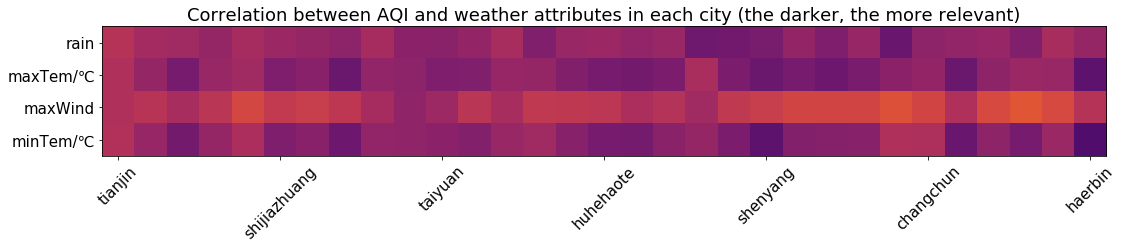

In [18]:
aqiDropDup.index = range(len(aqiDropDup))
rainMatchAqi.index = range(len(aqiDropDup))
maxTemMatchAqi.index = range(len(aqiDropDup))
maxWindMatchAqi.index = range(len(aqiDropDup))
minTemMatchAqi.index = range(len(aqiDropDup))

# 取出每个城市的各项数据，与AQI合并到一张表中作相关性分析
# 将各城市的相关性分析数据合并到一张表heatdata
# 作heatdata数据表的颜色映射，类似热力图
tmp = aqiDropDup['日期']
tmp = pd.concat([tmp, aqiDropDup['beijingAQI']],axis=1)
tmp = pd.concat([tmp, rainMatchAqi['beijing是否有雨']],axis=1)
tmp = pd.concat([tmp, maxTemMatchAqi['beijing最高气温/℃']],axis=1)
tmp = pd.concat([tmp, maxWindMatchAqi['beijing最大风力/级']],axis=1)
tmp = pd.concat([tmp, minTemMatchAqi['beijing最低气温/℃']],axis=1)
heatdata = tmp.corr()['beijingAQI']
heatdata.index = range(5)
for city in citySet:
    if (city=='beijing'):
        continue
    tmp = aqiDropDup['日期']
    tmp = pd.concat([tmp, aqiDropDup[city+'AQI']],axis=1)
    tmp = pd.concat([tmp, rainMatchAqi[city+'是否有雨']],axis=1)
    tmp = pd.concat([tmp, maxTemMatchAqi[city+'最高气温/℃']],axis=1)
    tmp = pd.concat([tmp, maxWindMatchAqi[city+'最大风力/级']],axis=1)
    tmp = pd.concat([tmp, minTemMatchAqi[city+'最低气温/℃']],axis=1)
    # 作相关性分析并将与AQI的相关性列合并到heatdata
    tmp = tmp.corr()[city+'AQI']
    tmp.index=range(5)
    heatdata = pd.concat([heatdata,tmp],axis=1)

heatdata.index = ['AQI','rain','maxTem','maxWind','minTem']
heatdata.drop(['AQI'],inplace=True)
heatdata.index = range(4)

# 作heatdata数据表的颜色映射，类似热力图
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
ax.imshow(heatdata, cmap=plt.get_cmap('inferno'),vmin=-1,vmax=1)
ax.set_xticklabels(citySet,rotation=45,fontsize=15)
ax.set_yticklabels(['AQI','rain','maxTem/℃','maxWind','minTem/℃'],fontsize=15)
ax.set_title("Correlation between AQI and weather attributes in each city (the darker, the more relevant)",fontsize=18)
fig.show()
heatdata.head()

#aqiDropDup['beijingAQI'].corr(rainMatchAqi['beijing是否有雨'])
#aqiDropDup['tianjinAQI'].corr(maxTemMatchAqi['tianjin最高气温/℃'])
#aqiDropDup['tianjinAQI'].corr(maxWindMatchAqi['tianjin最大风力/级'])
#aqiDropDup['tianjinAQI'].corr(minTemMatchAqi['tianjin最低气温/℃'])


* 温度与AQI系数的相关性最高，呈负相关，是否下雨次之
* 但是相关系数都不是很高，效果不很理想，可能由于AQI指数较为复杂，有很多影响因素

### 应用决策树根据天气情况的特征来预测当日空气质量等级
* 仅使用上海的数据训练决策树
* 将AQI等级转变为空气质量等级，50为一档，作为空气质量等级标签

In [102]:
ml = aqiDropDup['日期']
ml = pd.concat([ml, aqiDropDup['shanghaiAQI']],axis=1)
ml = pd.concat([ml, rainMatchAqi['shanghai是否有雨']],axis=1)
ml = pd.concat([ml, maxTemMatchAqi['shanghai最高气温/℃']],axis=1)
ml = pd.concat([ml, maxWindMatchAqi['shanghai最大风力/级']],axis=1)
ml = pd.concat([ml, minTemMatchAqi['shanghai最低气温/℃']],axis=1)
ml['level'] = ml['shanghaiAQI'] // 50
ml.drop([1783,1784], inplace=True)
ml.tail()

,日期,shanghaiAQI,shanghai是否有雨,shanghai最高气温/℃,shanghai最大风力/级,shanghai最低气温/℃,level
1778,2018-11-24,81.0,0,19,2,11,1.0
1779,2018-11-25,101.0,0,19,2,12,2.0
1780,2018-11-26,159.0,0,20,2,13,3.0
1781,2018-11-27,137.0,0,19,2,13,2.0
1782,2018-11-28,98.0,0,17,2,12,1.0


#### 分割数据作为训练样本

In [103]:
X_train = ml.ix[:,2:6]
y_train = ml['level']
X_train[0:5]

E:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


,shanghai是否有雨,shanghai最高气温/℃,shanghai最大风力/级,shanghai最低气温/℃
0,0,5,4,14
1,0,8,4,16
2,0,6,4,14
3,0,3,4,10
4,0,5,4,10


#### 应用决策树

In [104]:
aqi_tree = tree.DecisionTreeClassifier(max_depth=3,min_samples_split=100,min_samples_leaf=100)
aqi_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### 在训练集上执行预测查看准确率

In [105]:
y_pred=bamboo_tree.predict(X)
accuracy_score(y_train, y_pred)

0.56421761076836796

#### 获取测试样本执行预测查看准确率
* 使用了临近的杭州数据

In [106]:
test = aqiDropDup['日期']
test = pd.concat([test, aqiDropDup['hangzhouAQI']],axis=1)
test = pd.concat([test, rainMatchAqi['hangzhou是否有雨']],axis=1)
test = pd.concat([test, maxTemMatchAqi['hangzhou最高气温/℃']],axis=1)
test = pd.concat([test, maxWindMatchAqi['hangzhou最大风力/级']],axis=1)
test = pd.concat([test, minTemMatchAqi['hangzhou最低气温/℃']],axis=1)
test['level'] = test['hangzhouAQI'] // 50
X_test = test.ix[:,2:6]
y_test = test['level']


E:\Anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [107]:
y_pred=aqi_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.6140056022408964

### 读入预处理的各城市月AQI平均值数据表，与发电量数据进行相关性分析
* 展示月均AQI数据前5行

In [979]:
aqiByMonth = pd.read_csv("data/aqiByMonth.csv",encoding='gbk')
aqiByMonth.head()

,日期,beijingAQI,tianjinAQI,shijiazhuangAQI,taiyuanAQI,huhehaoteAQI,shenyangAQI,changchunAQI,haerbinAQI,shanghaiAQI,...,chongqingAQI,chengduAQI,guiyangAQI,kunmingAQI,lasaAQI,xianAQI,lanzhouAQI,xiningAQI,yinchuanAQI,wulumuqiAQI
0,2014-01,121.000000,147.966667,297.333333,113.833333,92.733333,118.466667,120.166667,159.20000,103.733333,...,171.400000,218.266667,123.033333,68.100000,51.100000,182.533333,108.333333,117.566667,90.466667,162.433333
1,2014-02,183.071429,128.642857,260.750000,135.178571,89.964286,130.750000,118.464286,149.25000,73.714286,...,113.642857,147.071429,68.571429,50.392857,65.071429,214.607143,93.285714,116.285714,98.000000,109.285714
2,2014-03,126.833333,152.766667,190.866667,100.366667,96.033333,110.166667,95.266667,79.50000,82.500000,...,76.600000,115.333333,65.000000,74.633333,54.766667,138.200000,100.833333,110.466667,94.666667,126.966667
3,2014-04,129.800000,123.900000,155.433333,100.933333,96.033333,100.766667,93.666667,81.40000,76.933333,...,62.966667,86.966667,64.500000,77.966667,69.666667,102.466667,109.866667,113.400000,96.366667,147.200000
4,2014-05,100.741935,104.483871,127.193548,92.870968,94.032258,82.322581,63.096774,50.83871,94.225806,...,70.322581,107.806452,67.096774,56.516129,68.967742,101.645161,104.000000,106.548387,75.580645,109.096774


#### 用折线图展示月均AQI变化情况
* 可以发现，AQI的变化情况与季节关系较大，冬季AQI指数较高，空气质量较差，符合实际
* 且观察波形峰值可发现，AQI指数在14年底到16年底上升，而近两年又又下降趋势，可以认为近年空气污染治理措施初见成效
* 注意 发电量数据仅到2018年10月，删除AQI的11月

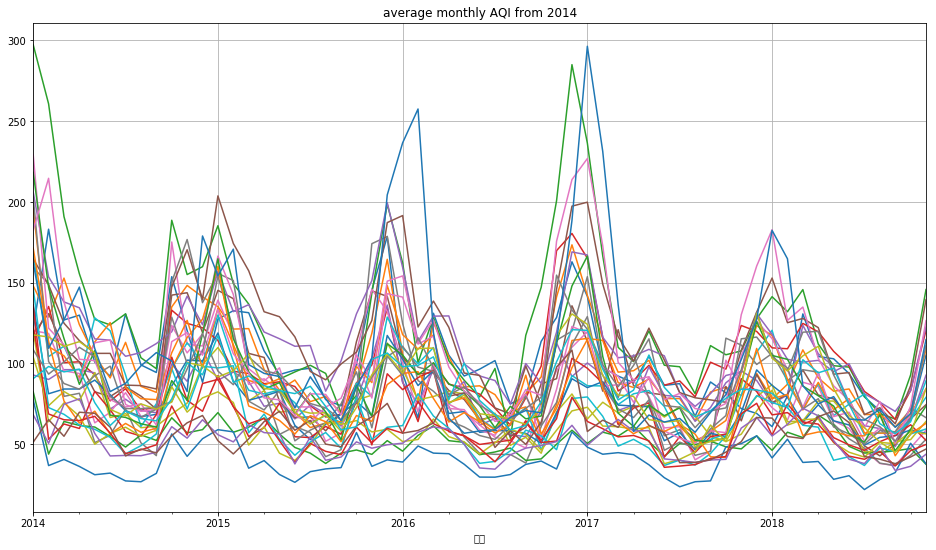

In [880]:
aqiByMonthTmp = pd.DataFrame(data = aqiByMonth.values, 
                            index=pd.to_datetime(aqiByMonth['日期']), 
                            columns=aqiByMonth.columns.values)
aqiByMonthTmp.plot(title="average monthly AQI from 2014", grid=True, legend=False,figsize=[16,9])


#### 读入发电量数据表，展示前5行

In [983]:
powerByMonth = pd.read_csv("data/power_cleaned.csv",encoding='gbk')
powerByMonth.head()

,place,2018-10,2018-9,2018-8,2018-7,2018-6,2018-5,2018-4,2018-3,2018-2,...,2014-10,2014-9,2014-8,2014-7,2014-6,2014-5,2014-4,2014-3,2014-2,2014-1
0,北京,27.5,28.9,43.2,41.8,36.3,26.2,23.3,35.9,38.305,...,19.4,16.3,27.1,35.5,24.8,21.3,21.3,28.9,32.3,37.6
1,天津,52.3,56.7,75.4,69.2,61.7,46.7,45.9,49.7,49.491,...,46.8,51.6,59.3,58.6,51.0,46.9,42.7,51.2,47.4,53.9
2,河北,229.6,224.4,269.7,285.1,251.3,233.7,222.1,233.6,231.898,...,191.1,191.3,217.6,233.0,217.5,218.4,206.8,210.0,176.7,205.5
3,山西,240.2,234.2,280.3,276.0,247.0,227.8,224.7,245.7,231.287,...,206.3,204.8,231.1,233.7,205.8,208.6,213.3,229.9,202.1,232.2
4,内蒙古,419.0,395.7,424.9,405.9,372.3,415.3,393.6,396.1,344.839,...,301.5,308.0,317.8,318.5,302.9,299.8,303.9,306.2,268.4,290.5


#### 计算AQI指数与发电量的相关性
* 由于两个数据表是反转的，且需要使用时间索引来合并
* 使用时间索引不熟悉，处理较为复杂

object
float64
58
58


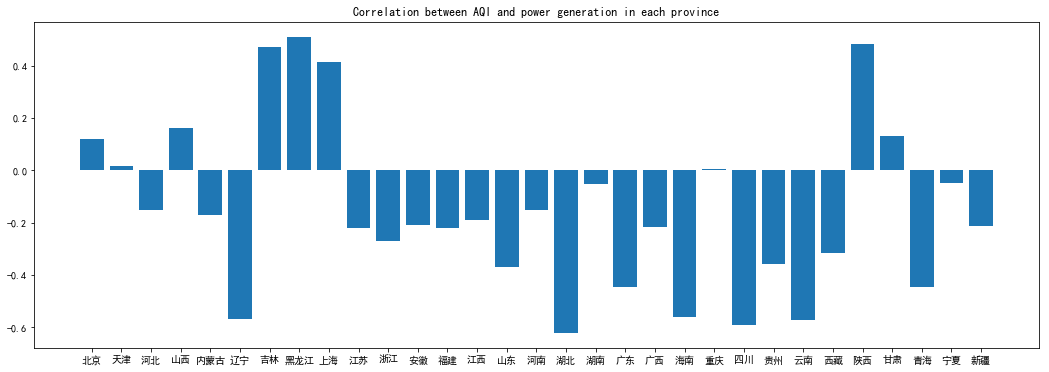

In [980]:
# 读取AQI数据，重构为时间索引dataframe，用月视角
aqiByMonth = pd.read_csv("data/aqiByMonth.csv",encoding='gbk')
aqiByMonth.drop(58,axis=0,inplace=True)
aqiByMonth = pd.DataFrame(data = aqiByMonth.values, 
                            index=pd.to_datetime(aqiByMonth['日期']), 
                            columns=aqiByMonth.columns.values)
aqiByMonth = aqiByMonth.to_period('M')

# 读取power数据，重构为时间索引dataframe并转置，用月视角
powerByMonth = pd.read_csv("data/power_cleaned.csv",encoding='gbk')
powerByMonth.sort_index(ascending=False)
placeIndex = powerByMonth.place
del powerByMonth['place']
powerByMonth = pd.DataFrame(data = powerByMonth.values, 
                            index=placeIndex, 
                            columns=powerByMonth.columns.values)
powerByMonth = powerByMonth.T
powerByMonth = pd.DataFrame(data = powerByMonth.values, 
                            index=pd.to_datetime(powerByMonth.index), 
                            columns=powerByMonth.columns.values)
powerByMonth = powerByMonth.to_period('M')

# 检查数据表数据类型
print(aqiByMonth['nanjingAQI'].dtypes)
print(powerByMonth['江苏'].dtypes)
print(aqiByMonth['nanjingAQI'].count())
print(powerByMonth['江苏'].count())

# 计算每个城市AQI指数与发电量相关指数
corrdata = []
for city,province in zip(citySet, provinceSet):
    aqiByMonth[city+'AQI'] = aqiByMonth[city+'AQI'].astype(float)
    corrdata.append(aqiByMonth[city+'AQI'].corr(powerByMonth[province]))
    #corrdata.append(tmp.corr().loc[city+'AQI',province])
'''
tmp = aqiByMonth[city+'AQI']
tmp = pd.concat([tmp,powerByMonth[province]],axis=1)
tmp[city+'AQI'] = tmp[city+'AQI'].astype(float)
tmp.corr().loc[city+'AQI',province]
# TODO, reserve? no need

'''
# 以相关系数作柱状图
rcParams['figure.figsize'] = (18,6)
rcParams['font.sans-serif'] = ['SimHei']
rcParams['axes.unicode_minus'] = False
plt.bar(x=provinceSet,height=corrdata)
plt.title('Correlation between AQI and power generation in each province')
rcParams['figure.figsize'] = (8,6)

* 各省发电量与AQI指数的相关系数图显示，存在正负相关，说明两者相关性不强，或存在地域性，也可能由于天气原因导致
* 可能由于夏季空调等的使用导致发电量大，而AQI在夏季相对较低；而冬季可能由于春节工厂歇业等情况，发电量又降低等各种因素导致相关性不大
* 可能需要用每个城市的常住人口，汽车保有量等数据来计算会更好


## 结论
1. 就AQI指数在空间上的分布来说，京津冀地区空气污染较为严重，就时间分布来说，空气污染在冬季较为严重，这些都符合所了解的实际情况
2. 就AQI月均指数变化情况来说，空气污染在前两年达到高峰，近一年有下降趋势，治理有一定效果
3. 天气情况与空气污染情况的一元相关性分析中，温度与AQI相关系数最高，呈负相关，是否下雨次之，但是相关系数都不是很高，效果不很理想，可能由于AQI指数较为复杂，有很多影响因素
4. 应用决策树进行的多元分析可以在60%左右的准确率预测空气污染情况
4. 天气情况与发电量的相关性分析中，发现相关系数正负都有，大部分为负相关，这可能说明这一部分分析效果不理想，发电量的变化与温度、工业、节假日等大量因素有关，可以进一步使用常住人口或者汽车保有量来作分析

### 总结
1. 做的工作
    * 使用了爬虫爬取所需数据
    * 根据需求进行了数据预处理和数据清洗，实际情况的数据会有很多缺失、不规范、不合需求等情况，预处理需要耗费大量时间
    * 对数据进行了统计分析可视化，使用了箱线图、地图、折线图等
    * 对数据间的关系应用了相关性分析
    * 应用了决策树用天气情况来预测空气污染情况
2. 不考虑效果欠佳的话，应该说基本完成了项目预期效果，通过项目体验了数据科学的过程，了解了数据工程师的任务，但真正工作上的数据分析必然更加复杂，总得来说收获还是非常大的，了解了一块未知的领域，学习使用了很多新技术，感谢老师和助教一学期的指导